# Find the ROI's $\Rightarrow$ get the top voxel

This notebook is used to find the regions of interest (ROIs) and extract the highest intense voxel for each of the found ROIs.

In [2]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 
import glob
import time
from copy import deepcopy
import numpy as np
import pandas as pd 

from nilearn import datasets, image
from nilearn import surface
from nilearn import plotting
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
from nilearn.regions import connected_regions
import nibabel as nib

from brainiak import image, io
from brainiak.isc import isc, isfc, permutation_isc
from brainiak.isc import compute_summary_statistic
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d 
import seaborn as sns 
import pandas as pd
from importlib import reload 
import scipy.io as sio
from scipy import stats

# import own functions
import utils
reload(utils)

#%autosave 30
%matplotlib inline
sns.set(style = 'white', context='talk', font_scale=1, rc={"lines.linewidth": 2})

In [3]:
# specify local path
path = '/Users/Daphne/data/'

# load relevant data
levels_betas = np.load(path+'bold_data_levels.npy')
iscs_r_levels = np.load(path+'iscs_r_levels.npy')

# load mask and get voxel coordinates
mask_arr = np.load(path+'mask_arr.npy') # all masks are the same
mask_mat = mask_arr[0] # so we can pick any one from the array
coords_mat = np.array(np.where(mask_mat == 1)) # so need one set of voxel coordinates for all
coords_mat[[0, 2]] = coords_mat[[2, 0]] # exchange the rows

# mask_nii is the functional mask, this selects the brain voxels
mask_nii = nib.load(os.path.join(path, 'mask.nii')) 

# this where we plot our mask ON (sometimes called brain_nii) - the anatomical/structural image
mean_nii = nib.load(os.path.join(path, 'mean.nii')) 

In [4]:
iscs_r_levels

array([[-0.08647298, -0.08264689,  0.05209291, ..., -0.04728233,
        -0.02028276, -0.0585491 ],
       [ 0.01931597,  0.04682847, -0.04335183, ...,  0.28666462,
         0.27016796, -0.18529388],
       [ 0.40445141,  0.44137352,  0.31407147, ...,  0.23743184,
         0.15753744, -0.14028751],
       ...,
       [ 0.1656714 ,  0.11414849,  0.03646999, ..., -0.11111457,
        -0.11722488,  0.23958578],
       [-0.3093235 , -0.3208494 , -0.26808857, ...,  0.04332081,
         0.14445493,  0.03816058],
       [ 0.02986205,  0.04564478, -0.09362682, ...,  0.18391026,
         0.20258632, -0.23755461]])

Display t statistics with a corresponding p < 0.01


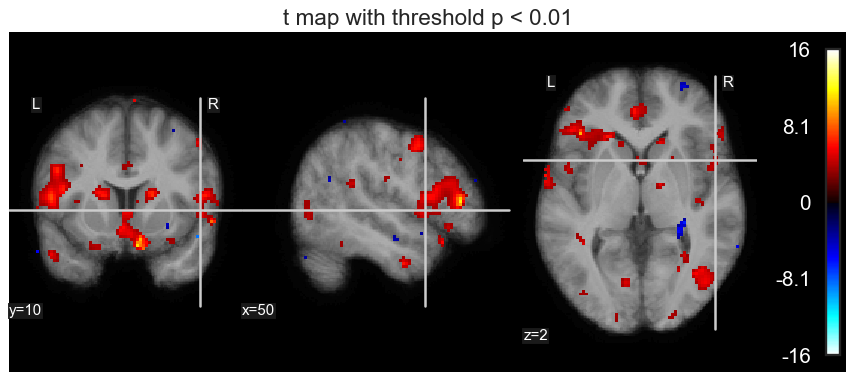

In [5]:
# remember we got 
tstats_levels, p_levels = stats.ttest_1samp(np.arctanh(iscs_r_levels), popmean=0)

# plot the t map and store the nifti image as the statistical image
# we store the thresholded nifti image
thresholded_stat_img = utils.plot_statistical_map(coords=coords_mat, 
                           tstats=tstats_levels, 
                           pvalues=p_levels, 
                           brain_nii=mean_nii, 
                           mask_nii=mask_nii, 
                           threshold=True,
                           theta=0.01,
                           cut_coords=[50, 10, 2],
                           vmax=None)
# x: saggital, y: coronal, z: axial

In [6]:
tstats_levels

array([ 0.25769104,  0.33136357, -0.53880119, ...,  2.16397128,
        2.75628968, -0.23457518])

In [7]:
view = plotting.view_img(thresholded_stat_img)


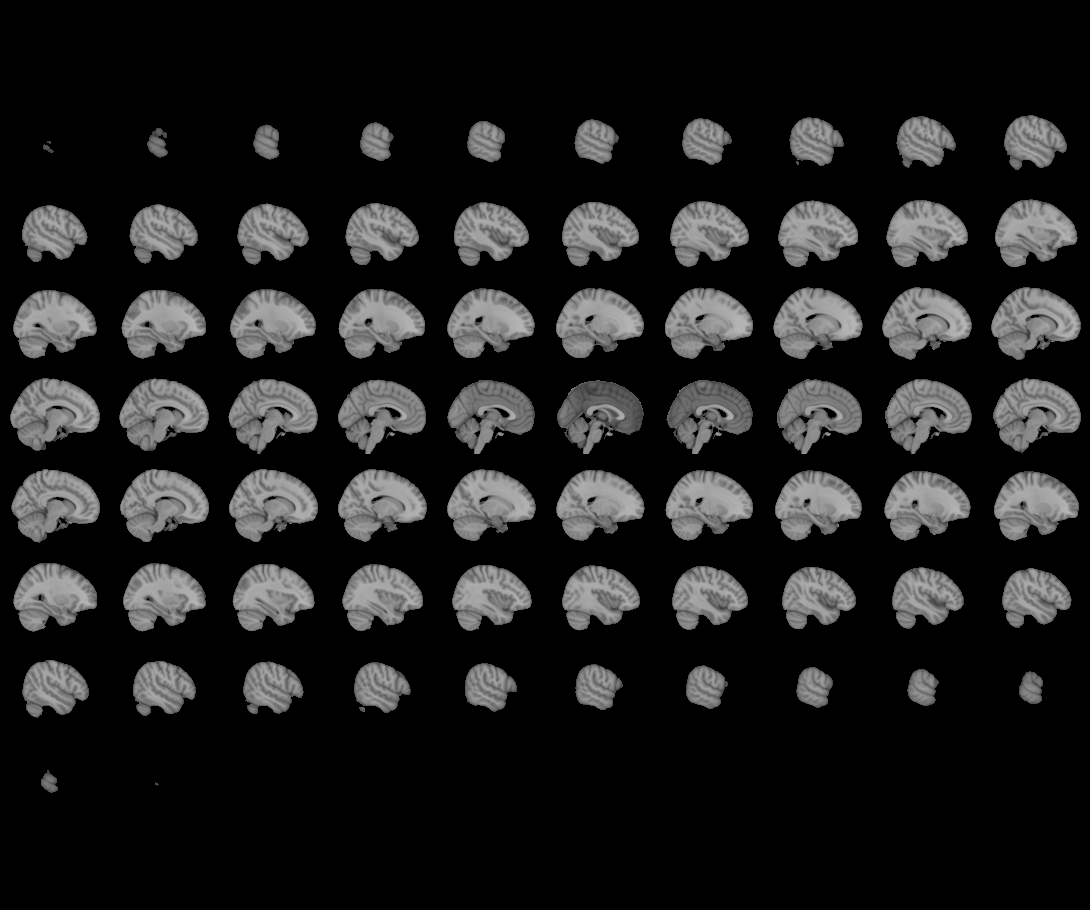
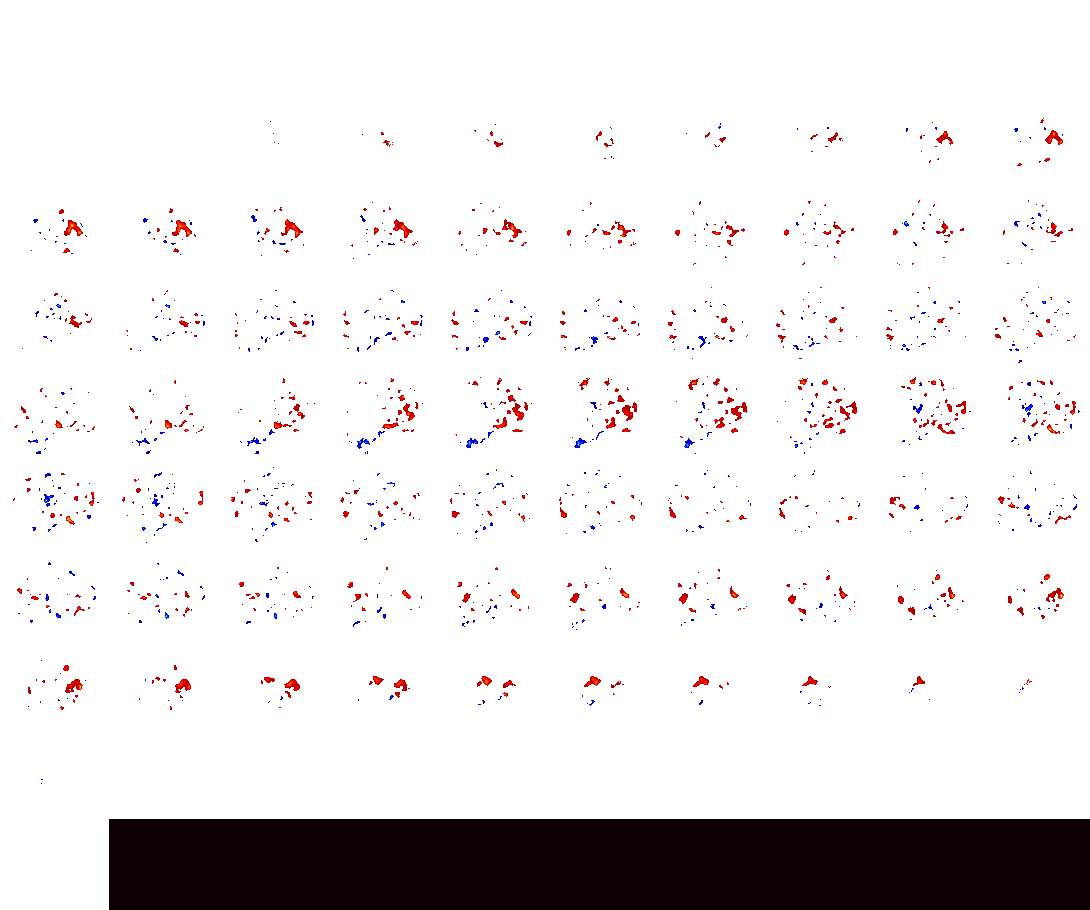

In [8]:
view

# 1 - ROI extraction using a t-statistical map

This is a combination of the [steps explained here](http://nilearn.github.io/auto_examples/04_manipulating_images/plot_extract_rois_statistical_maps.html#sphx-glr-auto-examples-04-manipulating-images-plot-extract-rois-statistical-maps-py) and [this tutorial](http://nilearn.github.io/auto_examples/04_manipulating_images/plot_roi_extraction.html#sphx-glr-auto-examples-04-manipulating-images-plot-roi-extraction-py)

Pick the top voxel for every blob of in the statistical t map, then use that top voxel to perform an ISC analysis with. There are different ways we can do this.

 
`functions:`

## 1.1 We threshold the stat map with the corresponding p values (p < 0.01)

Returned by `utils.plot_statistical_map()` see `utils.py` for the code.

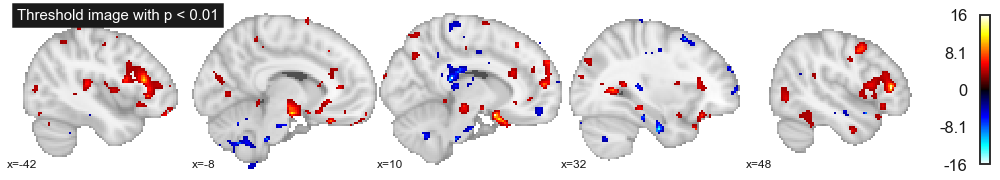

In [9]:
# Showing percentile threshold image
plotting.plot_stat_map(thresholded_stat_img, display_mode='x', cut_coords=5,
                       title='Threshold image with p < 0.01', colorbar=True);

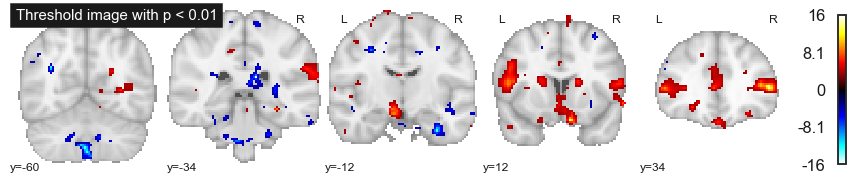

In [10]:
# Showing percentile threshold image
plotting.plot_stat_map(thresholded_stat_img, display_mode='y', cut_coords=5,
                       title='Threshold image with p < 0.01', colorbar=True);

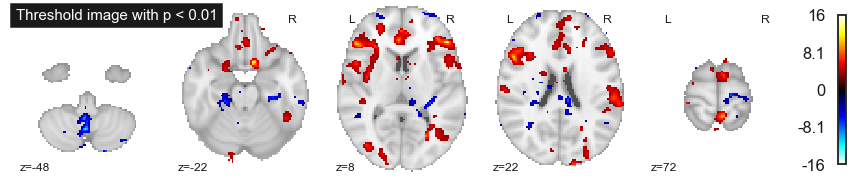

In [11]:
# Showing percentile threshold image
plotting.plot_stat_map(thresholded_stat_img, display_mode='z', cut_coords=5,
                       title='Threshold image with p < 0.01', colorbar=True);

## 1.2 Choose the `min_region_size` 

`connected_regions()`: extraction of brain connected regions into separate regions.

Choose

`min_region_size:` int, default 1350 mm^3, optional

> Minimum volume in mm3 for a region to be kept. For example, if the voxel size is 3x3x3 mm then the volume of the voxel is 27mm^3. By default, it is 1350mm^3 which means we take minimum size of 1350 / 27 = 50 voxels 

In [12]:
regions_thresholded_img, index = connected_regions(thresholded_stat_img, min_region_size=1350)

## 1.3 Display extracted ROIs

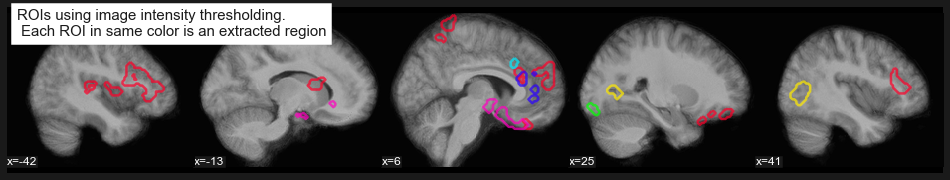

In [13]:
title = ("ROIs using image intensity thresholding. "
         "\n Each ROI in same color is an extracted region")
plotting.plot_prob_atlas(regions_thresholded_img, bg_img=mean_nii,
                         view_type='contours', display_mode='x',
                         cut_coords=5, title=title);

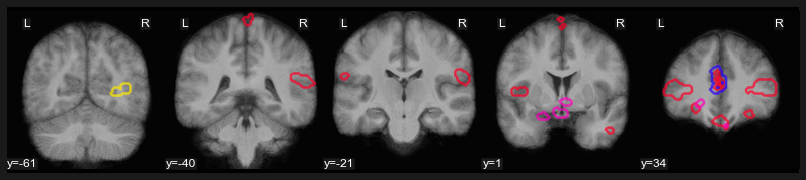

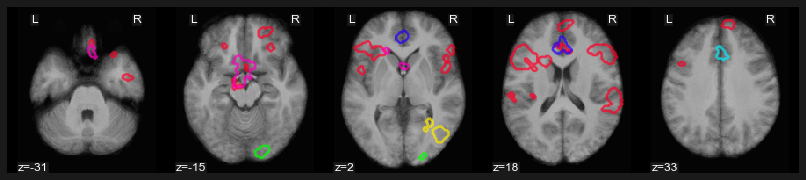

In [14]:
plotting.plot_prob_atlas(regions_thresholded_img, bg_img=mean_nii,
                         view_type='contours', display_mode='y',
                         cut_coords=5);

plotting.plot_prob_atlas(regions_thresholded_img, bg_img=mean_nii,
                         view_type='contours', display_mode='z',
                         cut_coords=5);

## Extract and display one ROI boolean mask

In [15]:
# get all the ROI boolean masks
roi_masks = regions_thresholded_img.dataobj

roi_masks.shape

(79, 95, 79, 6)

In [16]:
# store all roi masks
roi_mask_one = roi_masks[:,:,:,0]
roi_mask_two = roi_masks[:,:,:,1]
roi_mask_three = roi_masks[:,:,:,2]
roi_mask_four = roi_masks[:,:,:,3]
roi_mask_five = roi_masks[:,:,:,4]
roi_mask_six = roi_masks[:,:,:,5]

In [17]:
# # === CHOOSE MASK ===
# ROI_MASK = roi_mask_one

# # convert to nifti object to plot
# roi_mask_nifti = nib.Nifti1Image(ROI_MASK, regions_thresholded_img.affine, regions_thresholded_img.header) 

# # The mask_nii mask overlayed on mean_nii
# plotting.plot_roi(roi_img=roi_mask_nifti, bg_img=mean_nii, black_bg=False, colorbar=True);

In [18]:
# === CHOOSE MASK ===
ROI_MASK = roi_mask_four
# ===================

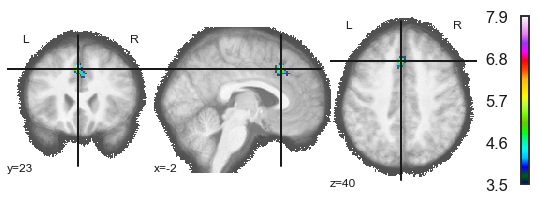

In [19]:
# convert to nifti object to plot
roi_mask_nifti = nib.Nifti1Image(ROI_MASK, regions_thresholded_img.affine, regions_thresholded_img.header) 

# The mask_nii mask overlayed on mean_nii
plotting.plot_roi(roi_img=roi_mask_nifti, bg_img=mean_nii, black_bg=False, colorbar=True);

## [SKIPPED] 1.4 Dilation

**Dilation.** Thresholded functional brain images often contain scattered voxels across the brain. To consolidate such brain images towards more compact shapes, we use a morphological dilation. This is a common step to be sure not to forget voxels located on the edge of a ROI. In other words, such operations can fill “holes” in masked voxel representations.

In [20]:
# from scipy import ndimage
# from nilearn.image import new_img_like

# # Input here is a binarized and intersected mask data from previous section
# dil_bin_p_values_and_vt = ndimage.binary_dilation(roi_mask_one)

# # Now, we visualize the same using `plot_roi` with data being converted to Nifti
# # image. In all new image like, reference image is the same but second argument
# # varies with data specific
# dil_bin_p_values_and_vt_img = new_img_like(
#     roi_mask_nifti_one,
#     dil_bin_p_values_and_vt.astype(np.int))
# # Visualization goes here without 'L', 'R' annotation and coordinates being the
# # same
# plotting.plot_roi(dil_bin_p_values_and_vt_img, mean_nii, title='Dilated mask');

## 1.5 Extract the coordinates that correspond to the highest t statistic

In [21]:
# check largest t values
max_t_values = np.sort(ROI_MASK.flatten())[::-1][:20] # get top 30 t stats
max_tstat = max_t_values[0] # take the highest t statistic

print(f'Largest values \n {max_t_values} \n')
print(f'Going for the voxel with a t stat of {max_tstat}\n')
 
top_vox_coords = np.where(ROI_MASK==max_tstat) # get x,y,z coords for voxel with the highest t statistic
print(f'The coordinates of the voxel with the highest t value: {top_vox_coords}')

# other roi coordinates
roi_coords = np.where(roi_mask_one!=0)

Largest values 
 [11.482618   8.323597   7.869107   7.473131   6.2747498  6.1312532
  5.9661727  5.9452424  5.927869   5.906111   5.759353   5.690345
  5.462875   5.462768   5.457614   5.3383865  5.2875123  5.19247
  5.1421213  5.0772734] 

Going for the voxel with a t stat of 11.48261833190918

The coordinates of the voxel with the highest t value: (array([42]), array([69]), array([57]))


## 1.6 Get the corresponding voxel from these coordinates

In [22]:
utils.get_vox_from_coords(coords_mat, top_vox_coords); # corresponding voxel

The coordinates correspond to voxel: 182512.


# Sanity check: plot the coordinate back on brain

In [23]:
# make all items in mask 1 execpt the top voxel, make that one 10
nonzero_indices = np.nonzero(ROI_MASK)

roi_boolean = np.zeros(ROI_MASK.shape)

roi_boolean[nonzero_indices] = 1 # convert all nonzero indices to a one

roi_boolean[top_vox_coords] = 10 # unfortunately can't see 1 voxel :(

In [24]:
from nibabel.affines import apply_affine

# put in simple lsit
top_vox_coords = [int(top_vox_coords[0]), int(top_vox_coords[1]), int(top_vox_coords[2])]

# translate back to mni space to check where the top voxel is 
mni_coords = apply_affine(aff=mask_nii.affine, pts=top_vox_coords) # from cor2mni

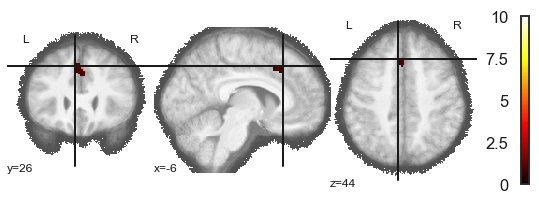

In [25]:
# convert to nifti object to plot
roi_check_nifti = nib.Nifti1Image(roi_boolean, regions_thresholded_img.affine, regions_thresholded_img.header) 

plotting.plot_stat_map(stat_map_img=roi_check_nifti, bg_img=mean_nii, black_bg=False, cut_coords=mni_coords);

In [26]:
reload(utils);

# All ROIs @momchil

Largest values 
 [14.864154  14.081531  11.685993  11.455738  11.111208  10.742732
 10.694143  10.691954  10.54375   10.446631  10.412895  10.358953
 10.346672  10.3410635 10.311057  10.200969  10.198994  10.115188
 10.086676  10.083764 ] 

Going for the voxel with a t stat of 14.864153861999512

The coordinates of the voxel with the highest t value: (array([15]), array([73]), array([39]))
The coordinates correspond to voxel: 104340.


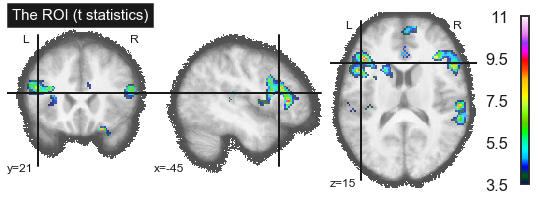

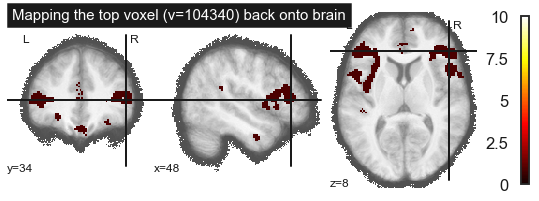

In [27]:
top_vox_roi_1 = utils.find_top_voxel_in_roi(roi_mask_one, regions_thresholded_img, coords_mat, mask_nii, mean_nii)

Largest values 
 [9.608257  9.187309  8.644466  7.7798195 7.1205783 6.9283237 6.890751
 6.4413605 6.4092374 6.383028  6.3267064 6.282204  6.2749248 6.2685294
 6.250696  6.207764  6.07008   6.0518017 6.03141   5.9917874] 

Going for the voxel with a t stat of 9.608257293701172

The coordinates of the voxel with the highest t value: (array([25]), array([23]), array([40]))
The coordinates correspond to voxel: 105967.


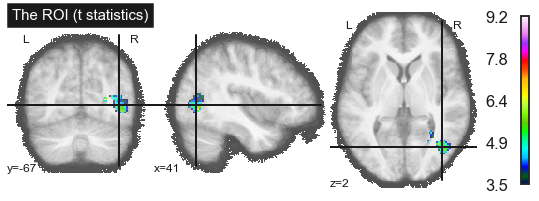

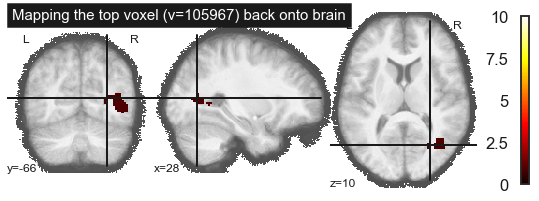

In [28]:
top_vox_roi_2 = utils.find_top_voxel_in_roi(roi_mask_two, regions_thresholded_img, coords_mat, mask_nii,mean_nii)

Largest values 
 [6.234541  6.1407447 6.106151  5.9786677 5.962545  5.9431014 5.9171734
 5.873319  5.8177476 5.7591276 5.7272353 5.723985  5.6917505 5.672834
 5.6460333 5.635841  5.5622067 5.559831  5.559756  5.5544424] 

Going for the voxel with a t stat of 6.234540939331055

The coordinates of the voxel with the highest t value: (array([29]), array([10]), array([30]))
The coordinates correspond to voxel: 57453.


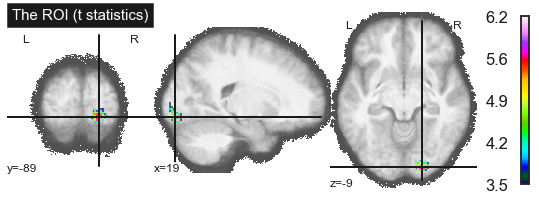

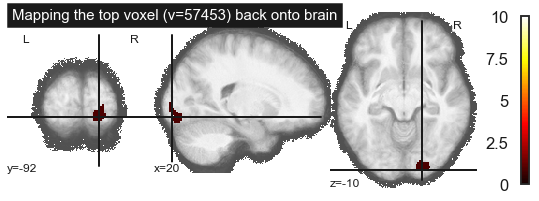

In [29]:
top_vox_roi_3 = utils.find_top_voxel_in_roi(roi_mask_three, regions_thresholded_img, coords_mat, mask_nii, mean_nii)

Largest values 
 [11.482618   8.323597   7.869107   7.473131   6.2747498  6.1312532
  5.9661727  5.9452424  5.927869   5.906111   5.759353   5.690345
  5.462875   5.462768   5.457614   5.3383865  5.2875123  5.19247
  5.1421213  5.0772734] 

Going for the voxel with a t stat of 11.48261833190918

The coordinates of the voxel with the highest t value: (array([42]), array([69]), array([57]))
The coordinates correspond to voxel: 182512.


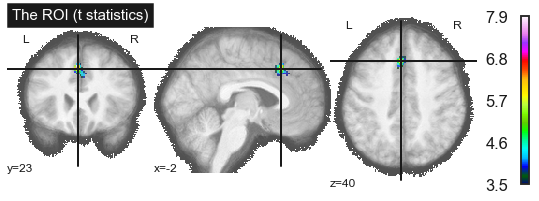

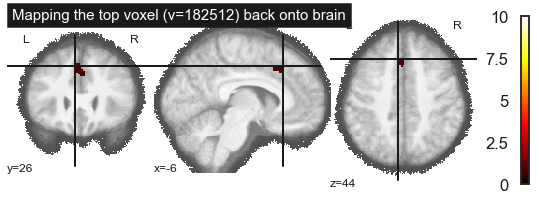

In [30]:
top_vox_roi_4 = utils.find_top_voxel_in_roi(roi_mask_four, regions_thresholded_img, coords_mat, mask_nii, mean_nii)

Largest values 
 [9.451322  8.620954  7.9476566 7.734406  7.6058483 7.447284  7.4235215
 7.38586   7.372807  7.313967  7.212605  7.0870786 6.9910975 6.907297
 6.7719994 6.605739  6.423531  6.419162  6.311819  6.176878 ] 

Going for the voxel with a t stat of 9.451321601867676

The coordinates of the voxel with the highest t value: (array([41]), array([74]), array([40]))
The coordinates correspond to voxel: 109243.


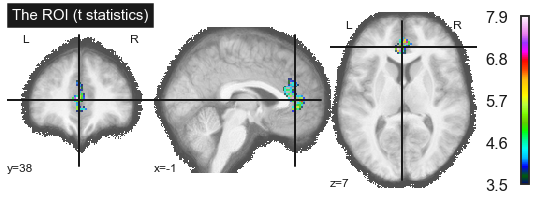

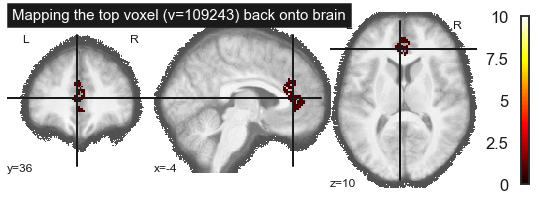

In [31]:
top_vox_roi_5 = utils.find_top_voxel_in_roi(roi_mask_five, regions_thresholded_img, coords_mat, mask_nii, mean_nii)

Largest values 
 [14.906314 14.453665 11.627149 11.463604 11.284254 10.244668 10.070791
 10.055251  9.882699  9.758172  9.557131  9.5174    9.451404  9.311026
  9.23231   9.08229   9.007768  8.922352  8.911326  8.823783] 

Going for the voxel with a t stat of 14.9063138961792

The coordinates of the voxel with the highest t value: (array([34]), array([60]), array([26]))
The coordinates correspond to voxel: 42904.


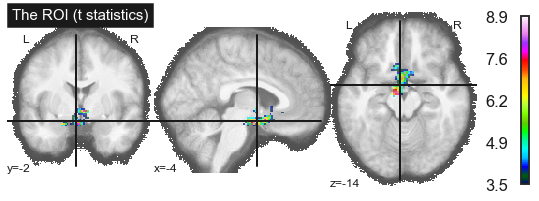

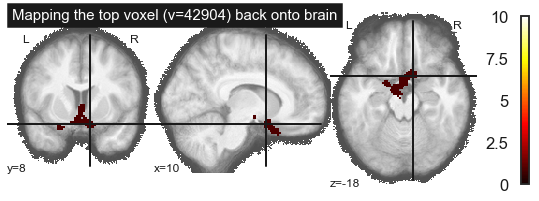

In [32]:
top_vox_roi_6 = utils.find_top_voxel_in_roi(roi_mask_six, regions_thresholded_img, coords_mat, mask_nii, mean_nii)

In [33]:
# this code can be used to plot 
# fig = plt.figure(figsize=(6,6))
# ax = plt.axes(projection="3d")
# ax.scatter3D(roi_coords[0], roi_coords[1], roi_coords[2], marker='o', color='g', s=0.05, zorder=-1);
# ax.scatter3D(top_vox_coords[0], top_vox_coords[1], top_vox_coords[2], marker='o', color='r', s=100, zorder=+1);
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z');
# ax.set_xlim([0,79])
# ax.set_ylim([0,95])
# ax.set_zlim([0,79])
# fig.suptitle('Top voxel in red and rest of the roi mask coordinates in green');